In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class APHomoTetramer(specifications.CoiledCoil):
    """Specification for creating antiparallel, homotetrameric coiled coils."""
    
    oligomeric_state = 4
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica, zshift):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 4 helices, we have 4 values for each of these, but in this case they
        # are the same as we're making a homotetramer
        self.aas = [helix_length, helix_length, helix_length, helix_length]
        self.major_radii = [radius, radius, radius, radius]
        self.major_pitches = [pitch, pitch, pitch, pitch]
        self.z_shifts = [0, zshift, 0, zshift]
        self.phi_c_alphas = [phica, phica, phica, phica]
        
        # We need to set the orientation of the helices
        self.orientations = [1, -1, 1, -1] # antiparallel specification

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GELKAIAQELKAIAKELKAIAWEEKAIAQG', 'GELKAIAQELKAIAKELKAIAWEEKAIAQG', 'GELKAIAQELKAIAKELKAIAWEEKAIAQG', 
             'GELKAIAQELKAIAKELKAIAWEEKAIAQG']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [15]:
parameters = [
    optimisation.Parameter.static('Helix Length', 30),
    optimisation.Parameter.dynamic('Radius', 6.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['f'], 27),
    optimisation.Parameter.dynamic('ZShift', 10, 10),
]

In [16]:
default_values = [x.default_value for x in parameters]
print(default_values)

[30, 6.0, 200, 154.2, 10]


### Genetic Algorithm

In [17]:
opt_ga = ev_opts.GA(APHomoTetramer, sequences, parameters, get_bude_total_energy)

In [18]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg    	std    	min     	max    
0  	63   	-1422.8	351.792	-1864.74	-687.66
1  	69   	-1711.33	80.5668	-1864.74	-1579.84
2  	67   	-1788.88	50.5624	-1880.5 	-1696.84
3  	62   	-1820.85	34.5684	-1880.5 	-1761.27
4  	72   	-1841.91	25.6353	-1903.72	-1801.39
5  	77   	-1854.67	17.5245	-1903.72	-1820.7 
6  	76   	-1866.34	12.5543	-1903.72	-1845.38
7  	71   	-1874.83	11.2776	-1903.72	-1856.83
8  	53   	-1880.81	9.32852	-1903.72	-1864.94
9  	82   	-1886.69	6.79542	-1906.1 	-1876.08
10 	69   	-1889.7 	6.0514 	-1906.1 	-1880.86
11 	63   	-1893.52	6.1496 	-1910.06	-1884.16
12 	69   	-1898.15	6.6852 	-1920.07	-1890.02
13 	83   	-1902.24	6.88493	-1923.03	-1891.97
14 	70   	-1908.02	7.82505	-1923.97	-1896.85
15 	82   	-1915.23	6.66511	-1924.45	-1903.78
16 	61   	-1918.8 	4.81655	-1924.45	-1906.81
17 	75   	-1921.63	2.45141	-1924.45	-1912.55
18 	83   	-1923.28	1.01993	-1924.58	-1920.56
19 	77   	-1923.98	0.380099	-1925.39	-1923.12
20 	66   	-1924.27	0.363578	-1925.39	-1923.74
21 	57   	-1

In [19]:
optimized_model_ga = opt_ga.best_model

In [20]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-1925.6818954003734

In [21]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [22]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

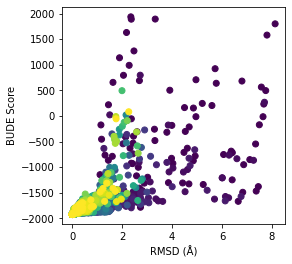

In [23]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUDE Score')

fig.savefig('ga.png')

In [24]:
f = open('CC-Hex-L24E-tet-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

### Differential Evolution

In [25]:
opt_de = ev_opts.DE(APHomoTetramer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [26]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max    
0  	100  	-1114.86	636.987	-1865.72	1357.68
1  	100  	-1422.21	356.682	-1865.72	79.6329
2  	100  	-1574.22	225.832	-1865.72	-810.17
3  	100  	-1668.5 	148.995	-1880.62	-870.437
4  	100  	-1717.94	104.617	-1880.62	-1142.41
5  	100  	-1759.38	75.7533	-1880.62	-1491.43
6  	100  	-1785.96	58.7939	-1880.62	-1612.17
7  	100  	-1812.11	41.1185	-1884.62	-1677.83
8  	100  	-1830.75	28.2251	-1884.62	-1720.57
9  	100  	-1841.39	23.5696	-1887.53	-1767.73
10 	100  	-1850.58	20.5456	-1887.57	-1792.07
11 	100  	-1856.02	21.07  	-1901.61	-1792.07
12 	100  	-1861.08	20.0351	-1912.79	-1810.52
13 	100  	-1869.05	21.2043	-1925.41	-1810.52
14 	100  	-1874.49	20.1972	-1925.41	-1827.87
15 	100  	-1879.99	18.8482	-1925.41	-1831.42
16 	100  	-1884.04	17.8737	-1925.41	-1832.04
17 	100  	-1888.24	14.8319	-1925.41	-1843.45
18 	100  	-1891.66	12.591 	-1925.41	-1855.96
19 	100  	-1893.37	12.0164	-1925.41	-1855.96
20 	100  	-1895.07	11.4339	-1925.41	-1855.96
21 	100  	-189

In [27]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-1925.4070560006958

In [28]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [29]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

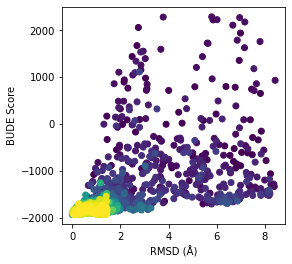

In [30]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUDE Score')

fig.savefig('de.png')

In [31]:
f = open('CC-Hex-L24E-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

### Particle Swarm Optimisation

In [32]:
opt_pso = ev_opts.PSO(APHomoTetramer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [33]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max    
0  	100  	-1009.12	895.123	-1880.83	2240.22
1  	90   	-1179.63	823.846	-1847.46	2240.22
2  	84   	-1235.14	553.474	-1874.31	2148.8 
3  	97   	-840.194	748.007	-1827.65	1700.49
4  	93   	-1086.8 	796.223	-1870.26	2964.41
5  	75   	-1291.16	730.945	-1864.2 	2964.41
6  	84   	-1394.12	477.443	-1884.79	953.564
7  	96   	-1350.34	638.027	-1890.31	2898.35
8  	88   	-1057.43	780.521	-1890.82	2898.35
9  	81   	-1222.49	643.456	-1863.5 	958.815
10 	82   	-1143.84	684.756	-1859.31	922.14 
11 	88   	-1398.5 	602.818	-1863.11	1295.78
12 	84   	-1292.19	560.165	-1864.73	1295.78
13 	81   	-920.036	837.366	-1857.89	1414.38
14 	65   	-971.279	773.716	-1866.13	1414.38
15 	79   	-1318.65	495.414	-1866.13	973.763
16 	76   	-1396.29	421.535	-1862   	973.763
17 	73   	-1246.56	580.601	-1862   	506.776
18 	75   	-738.94 	810.157	-1886.26	1528.78
19 	53   	-1033.1 	709.745	-1862   	1528.78
20 	76   	-1375.32	437.721	-1884.15	623.948
21 	86   	-1229.19	610.279	-1840

In [34]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-1898.716670657644

In [35]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [36]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

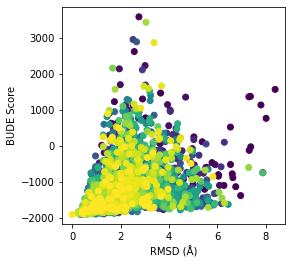

In [37]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUDE Score')

fig.savefig('pso.png')

In [38]:
f = open('CC-Hex-L24E-tet-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

### Covariance Matrix Adaptive Evolutionary Strategy

In [39]:
opt_cmaes = ev_opts.CMAES(APHomoTetramer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [40]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max    
0  	100  	-945.589	496.339	-1784.97	751.534
1  	100  	-1162.87	608.947	-1875.32	1410.11
2  	100  	-1234.98	604.255	-1851.13	912.238
3  	100  	-1508.16	424.153	-1885.09	99.9901
4  	100  	-1720.84	103.947	-1875.39	-1223.25
5  	100  	-1760.33	118.164	-1899.57	-797.078
6  	100  	-1755.84	135.671	-1879.86	-606.375
7  	100  	-1796.09	59.72  	-1889.76	-1625.12
8  	100  	-1826.61	49.7564	-1892.99	-1658.6 
9  	100  	-1849.24	35.2275	-1893.69	-1718.36
10 	100  	-1863.75	22.4519	-1904.18	-1756.93
11 	100  	-1867.11	28.3737	-1902.99	-1747.84
12 	100  	-1863.94	32.3021	-1898.29	-1751.14
13 	100  	-1855   	49.4784	-1901.07	-1654.33
14 	100  	-1878.22	24.909 	-1904.79	-1742.61
15 	100  	-1883.45	22.9607	-1918.4 	-1779.51
16 	100  	-1874.21	33.4932	-1915.57	-1747.32
17 	100  	-1888.42	15.0048	-1925.36	-1831.74
18 	100  	-1890.2 	14.1704	-1915.89	-1826.32
19 	100  	-1895.37	13.9608	-1920.42	-1836.67
20 	100  	-1893.75	20.2052	-1922.44	-1825.3 
21 	100  	-1886

In [41]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-1928.2155493989515

In [42]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [43]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

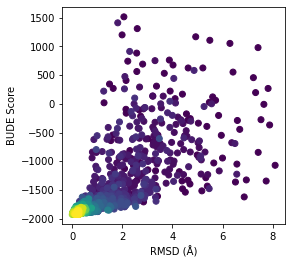

In [44]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUDE Score')

fig.savefig('cmaes.png')

In [45]:
f = open('CC-Hex-L24E-tet-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)